In [2]:
!pip install stable_baselines3

In [68]:
import gymnasium as gym
from gymnasium import Env, spaces
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
import time
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv
from transformers import AutoTokenizer, AutoModelForCausalLM
from tensorflow import keras
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

In [45]:
print(np.argmax(y_test_one_hot))

3


In [62]:

# Charger et prétraiter le dataset CIFAR-10
def load_cifar10():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Convertir les données en numpy arrays
    x_train = np.array([image.numpy() for image, _ in train_dataset])
    y_train = np.array([label for _, label in train_dataset])
    x_test = np.array([image.numpy() for image, _ in test_dataset])
    y_test = np.array([label for _, label in test_dataset])

    # Transposer les dimensions pour Keras : (N, C, H, W) -> (N, H, W, C)
    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)

    # Encodage one-hot des labels
    y_train_one_hot = to_categorical(y_train, num_classes=10)
    y_test_one_hot = to_categorical(y_test, num_classes=10)

    return x_train, y_train_one_hot, x_test, y_test_one_hot


# Fonction pour entraîner le CNN
def keras_train(x_train, y_train_one_hot, x_test, y_test_one_hot, batch_size=32, epochs=10):
    model = Sequential()

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))  # 10 classes pour CIFAR-10

    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.002), metrics=["accuracy"])
    model.summary()

    start_time = time.time()
    model.fit(x_train, y_train_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.2)
    end_time = time.time()

    score = model.evaluate(x_test, y_test_one_hot, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    print("Training Time:", end_time - start_time)

    # Enregistrer le modèle
    model.save('./cnn_model.keras')
    return model

In [63]:
# Environnement RL personnalisé
class Cifar10Env(Env):
    def __init__(self, cnn_model):
        super().__init__()

        # Définition de l'espace d'observation (espace des caractéristiques extraites)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(10,), dtype=np.float32)

        # Définition de l'espace d'action
        self.action_space = spaces.Discrete(10)

        # Charger le dataset CIFAR-10
        transform = transforms.Compose([transforms.ToTensor()])
        self.dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        self.dataloader = DataLoader(self.dataset, batch_size=1, shuffle=True)
        self.data_iter = iter(self.dataloader)

        # Modèle CNN pour extraire les caractéristiques
        self.cnn_model = cnn_model

        # Sélectionner un exemple réel du dataset pour initialiser le modèle
        example_image, _ = next(iter(self.dataloader))  # Prendre un exemple du dataset
        example_image = example_image.numpy()[0].transpose(1, 2, 0)  # Convertir en format (H, W, C)
        example_image = example_image.astype(np.float32)  # Assurer le bon type de données

        # Initialiser le modèle avec l'exemple réel
        _ = self.cnn_model.predict(example_image[np.newaxis ])  # Ajouter une dimension de batch
        input_layer = cnn_model.layers[0].input
        output_layer = cnn_model.layers[-1].output
        self.feature_extractor = Model(inputs=input_layer, outputs=output_layer)

    def _next_image(self):
        try:
            image, label = next(self.data_iter)
        except StopIteration:
            self.data_iter = iter(self.dataloader)  # Recharger le dataloader si on arrive à la fin
            image, label = next(self.data_iter)
        return image.numpy()[0].transpose(1, 2, 0), label.item()

    def step(self, action):
        image, label = self._next_image()

        # Extraire les caractéristiques avec le CNN
        features = self.feature_extractor.predict(image[np.newaxis])

        # Comparer l'action avec le label réel
        if action == label:
            reward = 10  # Bonne prédiction
        else:
            reward = -50  # Mauvaise prédiction

        terminated = False  # L'épisode ne se termine jamais naturellement
        truncated = False  # Pas de troncature
        info = {}

        return features, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        image, label = self._next_image()
        features = self.feature_extractor.predict(image[np.newaxis])
        return features, {}

    def render(self, mode="human"):
        pass  # Pas de rendu nécessaire

In [64]:
# Charger les données CIFAR-10
x_train, y_train, x_test, y_test = load_cifar10()

# Entraîner le CNN
cnn_model = keras_train(x_train, y_train, x_test, y_test, batch_size=32, epochs=50)


Files already downloaded and verified
Files already downloaded and verified


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 105ms/step - accuracy: 0.3340 - loss: 1.9984 - val_accuracy: 0.5461 - val_loss: 1.2676
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - accuracy: 0.5597 - loss: 1.2294 - val_accuracy: 0.6481 - val_loss: 0.9826
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 135s 108ms/step - accuracy: 0.6357 - loss: 1.0342 - val_accuracy: 0.7221 - val_loss: 0.7918
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 149s 119ms/step - accuracy: 0.6793 - loss: 0.9162 - val_accuracy: 0.7522 - val_loss: 0.7136
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.7113 - loss: 0.8419 - val_accuracy: 0.7661 - val_loss: 0.6788
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - accuracy: 0.7285 - loss: 0.7844 - val_accuracy: 0.7107 - val_loss: 0.8590
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 133s 106ms/step - accuracy: 0.7415 - loss: 0.7592 - val_accuracy: 0.7526 - val_loss: 0.7067
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 131s 105ms/step - acc

In [66]:
from stable_baselines3.common.callbacks import BaseCallback

class EarlyStoppingCallback(BaseCallback):
    def __init__(self, max_iterations=100, verbose=0):
        super(EarlyStoppingCallback, self).__init__(verbose)
        self.max_iterations = max_iterations
        self.current_iteration = 0

    def _on_step(self) -> bool:
        self.current_iteration += 1
        if self.current_iteration >= self.max_iterations:
            return False  # Arrêter l'entraînement
        return True  # Continuer l'entraînement

def cifar10_dqn(cnn_model):
    log_dir = "./logs/cifar10_dqn"

    env = Cifar10Env(cnn_model)
    env = Monitor(env)

    model = DQN(
        "MlpPolicy",
        env,
        verbose=1,
        tensorboard_log=log_dir
    )

    # Utiliser un callback pour arrêter après 100 itérations
    early_stopping_callback = EarlyStoppingCallback(max_iterations=5000)
    model.learn(total_timesteps=int(1.2e5), callback=early_stopping_callback)
    model.save("dqn_cifar10")
    env.close()
    return model

In [77]:
# Charger les données CIFAR-10
x_train, y_train_one_hot, x_test, y_test_one_hot = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:

# Charger le modèle CNN
cnn_model = load_model('./cnn_model.keras')

# Entraîner l'agent RL avec seulement 100 itérations
start_time = time.time()
dqn_model = cifar10_dqn(cnn_model)
print("DQN Training Time:", time.time() - start_time)

Files already downloaded and verified
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Using cpu device
Wrapping the env in a DummyVecEnv.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Logging to ./logs/cifar10_dqn\DQN_9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1

In [69]:
class AccuracyCallback(BaseCallback):
    def __init__(self, eval_env, eval_freq=1000, verbose=0):
        super(AccuracyCallback, self).__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.accuracies = []

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            accuracy = self.evaluate_accuracy()
            self.accuracies.append(accuracy)
            print(f"Accuracy at step {self.n_calls}: {accuracy}")
        return True

    def evaluate_accuracy(self):
        total_correct = 0
        total_samples = 0
        for _ in range(10):  # Evaluate on 10 episodes
            obs = self.eval_env.reset()
            done = False
            while not done:
                action, _states = self.model.predict(obs, deterministic=True)
                obs, rewards, done, info = self.eval_env.step(action)
                if done:
                    if rewards == 10:  # Assuming reward of 10 means correct prediction
                        total_correct += 1
                    total_samples += 1
        return total_correct / total_samples if total_samples > 0 else 0

In [81]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Charger le modèle et le tokenizer une seule fois (en dehors de la fonction)
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")


# Cache pour stocker les réponses déjà générées
pet_info_cache = {}

In [89]:
def get_pet_info(pet_class):
    # Vérifier si la réponse est déjà dans le cache
    if pet_class in pet_info_cache:
        return pet_info_cache[pet_class]

    # Générer le prompt
    prompt = f"Réponds comme un expert en animaux.\n\nDonne-moi des informations détaillées sur les {pet_class}s.\nRéponse :"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Générer la réponse avec des paramètres optimisés
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,  
            temperature=0.25,     
            top_p=0.5,           
            do_sample=True      
        )

    # Décoder la réponse
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.replace(prompt, "").strip()

    # Stocker la réponse dans le cache
    pet_info_cache[pet_class] = response

    return response

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

x_train, y_train_one_hot, x_test, y_test_one_hot = load_cifar10()

rl_model = DQN.load("./dqn_cifar10")
cnn_model = load_model('./cnn_model.keras')

env = Cifar10Env(cnn_model)
env = Monitor(env)

# Sélectionner une image aléatoire dans le dataset de test
random_index = np.random.randint(0, len(x_test))  
random_image = x_test[random_index]  
random_label = y_test_one_hot[random_index]  

# Extraire les caractéristiques de l'image avec le CNN
random_image_batch = np.expand_dims(random_image, axis=0)  
features = cnn_model.predict(random_image_batch)  

# Faire une prédiction avec le modèle DQN
action, _ = rl_model.predict(features, deterministic=True)
action_scalar = action.item() 

# Afficher l'action prédite
print("Action prédite :", action_scalar)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Action prédite : 0


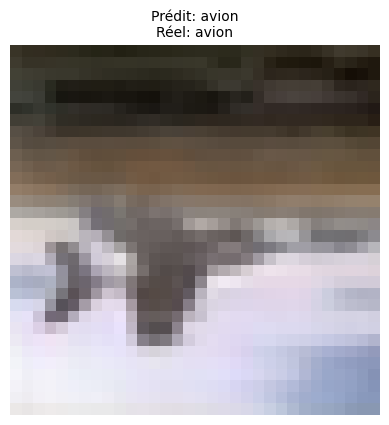

Informations sur la classe:
Les avions sont des véhicules qui volent et transportaient à l'époque des mots. Ils ont été inventés en 1860 par l'ingénieur anglais Joseph Wright de Wright. Wright a construit


In [93]:
class_names = [
    "avion", "voiture", "oiseau", "chat", "cerf",
    "chien", "grenouille", "cheval", "bateau", "camion"
]

predicted_class_name = class_names[action_scalar]

# Obtenir la classe réelle
true_class_index = np.argmax(random_label)  # Utiliser le label de l'image sélectionnée
true_class_name = class_names[true_class_index]

# Générer des informations sur l'animal avec le modèle de texte
reponse = get_pet_info(predicted_class_name)

# Afficher l'image avec les labels
plt.imshow(random_image)  # Afficher l'image sélectionnée
plt.axis('off')  # Désactiver les axes
plt.title(f"Prédit: {predicted_class_name}\nRéel: {true_class_name}", fontsize=10)
plt.show()

# Afficher la réponse générée
print("Informations sur la classe:")
print(reponse)